In [1]:
import numpy as np
from scipy.signal import StateSpace, lsim
import matplotlib.pyplot as plt
from numpy import linalg as LA
import cvxpy as cp
import dill

In [2]:
#dill.load_session('notebook_env.db')       #Uncomment it to load previous session

In [3]:
p=0.2
q=0.3
M=np.matrix([[p,1-p],[1-q,q]])


infeasibility_flaga=0
infeasibility_flagb=0

In [4]:
a=np.random.rand(2)
b=np.random.rand(2)
a,b

(array([0.31022858, 0.96464759]), array([0.36354262, 0.42519085]))

In [5]:
Q=np.outer(a,a)
R=np.outer(b,b)


pd1=0.5*np.random.rand(1)
pd2=0.5*np.random.rand(1)

I=np.array([[1,0],[0,1]])

Q=Q+pd1*I
R=R+pd2*I

mode_difference_std_dev=0.05

In [6]:
A1=np.random.rand(2,2)
B1=np.random.rand(2,2)
A2=A1+np.random.normal(0,mode_difference_std_dev,A1.shape)
B2=B1+np.random.normal(0,mode_difference_std_dev,B1.shape)
var1=0.01*np.random.rand(1)
var2=0.01*np.random.rand(1)
K=np.random.rand(2,2)



#scale=0.1

scale1=0.1
scale2=0.1
K=scale1*K
A1=scale1*A1
A2=scale2*A2
B1=scale1*B1
B2=scale2*B2
var1=scale1*scale1*var1
var2=scale2*scale2*var2



In [7]:

LA.norm(A1+B1.dot(K),2)


0.13213978975240476

In [8]:
LA.norm(A2+B2.dot(K),2)

0.13223925867429467

In [9]:
time=np.arange(0,10000,1e-3)
time.shape
cost=np.zeros((time.shape[0]))
x_norm=np.zeros((time.shape[0]))

In [10]:
#Here we run the previous Riccati to empirically find a safe nu, note we use a random policy K instead of the Riccati
# equation based optimal policy to get a safe upper bound and find all the hyperparameters for both modes a and b.



#Starting Mode a

x_dynamicsa=np.zeros((2,time.shape[0]))
x_0a=np.random.rand(2)
x_dynamicsa[:,0]=x_0a


u_0a=K.dot(x_0a)

costa=np.zeros((time.shape[0]))
x_norma=np.zeros((time.shape[0]))

c_0a=x_0a.dot((Q.dot(x_0a)))+u_0a.dot((R.dot(u_0a)))

costa[0]=c_0a
x_norma[0]=LA.norm(x_0a,2)

for t in range(1,time.shape[0]):
    xprev=x_dynamicsa[:,t-1]
    uprev=K.dot(xprev)
    xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,var1,xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(costa[t-1]*(t)+ct)/(t+1)
    x_norma[t]=LA.norm(xt,2)
    costa[t]=c
    x_dynamicsa[:,t]=xt
    
Final_Costa=(costa[time.shape[0]-1]*(time.shape[0])+x_dynamicsa[:,time.shape[0]-1].dot(Q.dot(x_dynamicsa[:,time.shape[0]-1])))/(time.shape[0]+1)

Final_Costa*=(time.shape[0]+1)

print(Final_Costa)



 


1.7121345897985008


In [11]:
#Now for Mode b

x_dynamicsb=np.zeros((2,time.shape[0]))
x_0b=np.random.rand(2)
x_dynamicsb[:,0]=x_0b


u_0b=K.dot(x_0b)

costb=np.zeros((time.shape[0]))
x_normb=np.zeros((time.shape[0]))

c_0b=x_0b.dot((Q.dot(x_0b)))+u_0b.dot((R.dot(u_0b)))

costb[0]=c_0b
x_normb[0]=LA.norm(x_0b,2)

for t in range(1,time.shape[0]):
    xprev=x_dynamicsb[:,t-1]
    uprev=K.dot(xprev)
    xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,var2,xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(costb[t-1]*(t)+ct)/(t+1)
    x_normb[t]=LA.norm(xt,2)
    costb[t]=c
    x_dynamicsb[:,t]=xt
    
Final_Costb=(costb[time.shape[0]-1]*(time.shape[0])+x_dynamicsb[:,time.shape[0]-1].dot(Q.dot(x_dynamicsb[:,time.shape[0]-1])))/(time.shape[0]+1)

Final_Costb*=(time.shape[0]+1)

print(Final_Costb)









0.12141806091579992


In [12]:
#Now we set the hyperparameters for the OSLO Algorithm, alpha0 and alpha1 are same for both modes.


n=4 #n=k+d=2+2=4

delta=0.1

q1,q2=LA.eigh(Q)
r1,r2=LA.eigh(R)


minq=np.amin(q1)
maxq=np.amax(q1)
minr=np.amin(r1)
maxr=np.amax(r1)



alpha0=min(minq,minr)

alpha1=max(maxq,maxr)

Augmenteda=np.column_stack((A1,B1))

nua=0.0000005  #Experimental value from repeatedly upper bounding last to last cell

          #based on the above experiment running the previous block several times, the average cost on convergence is

         # always upper bounded by the value of nu chosen so J* is definitely upper bounded by it 

vhia=LA.norm(Augmenteda,2)





Augmentedb=np.column_stack((A2,B2))

nub=0.00000005  #Experimental value from repeatedly upper bounding last cell

          #based on the above experiment running the previous block several times, the average cost on convergence is

         # always upper bounded by the value of nu chosen so J* is definitely upper bounded by it 

vhib=LA.norm(Augmentedb,2)




In [13]:
#Line 2 of the algorithm; initializing parameters

mua=5*vhia*np.sqrt(time.shape[0])


lamdaa=(2048*np.power(nua,5)*vhia*np.sqrt(time.shape[0]))/(np.power(alpha0,5)*np.power(var1,5))

betaa=(256*1024*np.power(nua,4)*n*n*np.log((time.shape[0])/delta))/(np.power(alpha0,4)*np.power(var1,3))

bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])


#Manually setting lamda and beta

lamdaa=1000000

betaa=0.0000001

#Try beta = 1 and lamda=0.01,0.1 both

#manual setting done


V1a=lamdaa*bigI



print(mua,lamdaa,betaa)

print(V1a)





mub=5*vhib*np.sqrt(time.shape[0])

lamdab=(2048*np.power(nub,5)*vhib*np.sqrt(time.shape[0]))/(np.power(alpha0,5)*np.power(var2,5))

betab=(256*1024*np.power(nub,4)*n*n*np.log((time.shape[0])/delta))/(np.power(alpha0,4)*np.power(var2,3))



#Manually setting lamda and beta

lamdab=1000000

betab=0.0000001

#manual setting done


V1b=lamdab*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])



print(mub,lamdab,betab)

print(V1b)










2436.189745859627 1000000 1e-07
[[1000000       0       0       0]
 [      0 1000000       0       0]
 [      0       0 1000000       0]
 [      0       0       0 1000000]]
2435.4985464518004 1000000 1e-07
[[1000000       0       0       0]
 [      0 1000000       0       0]
 [      0       0 1000000       0]
 [      0       0       0 1000000]]


In [14]:
# We set further parameters for input of the algorithm (1st line in the paper)


delta=0.1

epsilona=1/(4*lamdaa)

epsa=0.0001 #Manually chosen epsilon

A0a=A1+np.sqrt(epsa/n)*np.random.rand(2,2)

B0a=B1+np.sqrt(epsa/n)*np.random.rand(2,2)

Wa=var1*I

epsilonb=1/(4*lamdab)

epsb=0.0001 #Manually chosen epsilon

A0b=A2+np.sqrt(epsb/n)*np.random.rand(2,2)

B0b=B2+np.sqrt(epsb/n)*np.random.rand(2,2)

Wb=var2*I






In [15]:
# We write a function to compute ridge regression for matrices for system parameter estimation

def square_matrix_ridge_regression(X,Y,Astar,lmda,beeta):
    t=1+X.shape[1]
    D=lmda*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    C=lmda*Astar
    for s in range(1,t):
        xs=X[:,s-1]
        ys=Y[:,s-1]
        C=C+(1/beeta)*np.outer(ys,xs)
        D=D+(1/beeta)*np.outer(xs,xs)
    return C.dot(np.linalg.inv(D))

In [16]:
 # A function for the big dot

def big_dot(A,B):
    return np.trace(np.dot(A.T,B))


In [17]:
# Function for the SDP solver for mode a

def SDP_solver_a(At,Bt,Vt,W,mu):
    Vtinv=np.linalg.inv(Vt)
    Sigma=cp.Variable((n,n))
    sxx=cp.Variable((2,2))
    suu=cp.Variable((2,2))
    constraints=[Sigma>>0]
    bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    ABt=np.column_stack((At,Bt))
    #Cost_Coefficient=np.array([[Q,[[1,0],[0,1]]],[[[1,0],[0,1]],R]])
    I=np.array([[1,0],[0,1]])
    
    Left=np.array([[1,0,0,0],[0,1,0,0]])
    Right=np.array([[1,0],[0,1],[0,0],[0,0]])
    
    constraints+=[ sxx  >> (((ABt)@Sigma)@(ABt.T))+W-mu*cp.trace((Sigma.T)@(Vtinv))*I ]
    
    constraints+=[ sxx == (Left@Sigma)@Right  ]
    
    Lefty=np.array([[0,0,1,0],[0,0,0,1]])
    Righty=np.array([[0,0],[0,0],[1,0],[0,1]])
    
    constraints+=[ suu == (Lefty@Sigma)@Righty  ]
    
    prob = cp.Problem(cp.Minimize(cp.trace(sxx.T @ Q + suu.T @ R)),constraints)
    prob.solve()
    if(Sigma.value is None):
        infeasibility_flaga=1
        print(prob.value)
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (bigI)
    else:
        infeasibility_flaga=0
    
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (Sigma.value)






In [18]:
# Function for the SDP solver for mode b

def SDP_solver_b(At,Bt,Vt,W,mu):
    Vtinv=np.linalg.inv(Vt)
    Sigma=cp.Variable((n,n))
    sxx=cp.Variable((2,2))
    suu=cp.Variable((2,2))
    constraints=[Sigma>>0]
    bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    ABt=np.column_stack((At,Bt))
    #Cost_Coefficient=np.array([[Q,[[1,0],[0,1]]],[[[1,0],[0,1]],R]])
    I=np.array([[1,0],[0,1]])
    
    Left=np.array([[1,0,0,0],[0,1,0,0]])
    Right=np.array([[1,0],[0,1],[0,0],[0,0]])
    
    constraints+=[ sxx  >> (((ABt)@Sigma)@(ABt.T))+W-mu*cp.trace((Sigma.T)@(Vtinv))*I ]
    
    constraints+=[ sxx == (Left@Sigma)@Right  ]
    
    Lefty=np.array([[0,0,1,0],[0,0,0,1]])
    Righty=np.array([[0,0],[0,0],[1,0],[0,1]])
    
    constraints+=[ suu == (Lefty@Sigma)@Righty  ]
    
    prob = cp.Problem(cp.Minimize(cp.trace(sxx.T @ Q + suu.T @ R)),constraints)
    prob.solve()
    if(Sigma.value is None):
        infeasibility_flagb=1
        print(prob.value)
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (bigI)
    else:
        infeasibility_flagb=0
    
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (Sigma.value)






In [19]:
#Now we prepare to run the dynamical system with policies as dictated by OSLO algorithm

x_dynamics=np.zeros((2,time.shape[0]))
z_dynamics=np.zeros((4,time.shape[0]))
x_0=np.random.rand(2)
x_dynamics[:,0]=x_0
z_dynamics[0:2,0]=x_0

#Now we assume the system begins at mode a

acount=1
bcount=0

#K0=np.random.rand(2,2)
#u_0=K0.dot(x_0)
#z_dynamics[2:4,0]=u_0




x_dynamicsa=np.zeros((2,time.shape[0]))
z_dynamicsa=np.zeros((4,time.shape[0]))

x_dynamicsb=np.zeros((2,time.shape[0]))
z_dynamicsb=np.zeros((4,time.shape[0]))

x_dynamicsa[:,0]=x_0
z_dynamicsa[0:2,0]=x_0
z_dynamicsb[0:2,0]=x_0
#z_dynamicsa[2:4,0]=u_0








A_dynamicsa=np.zeros((time.shape[0],2,2))
B_dynamicsa=np.zeros((time.shape[0],2,2))
K_dynamicsa=np.zeros((time.shape[0],2,2))

A_dynamicsa[0]=A0a
B_dynamicsa[0]=B0a
#K_dynamicsa[0]=K0

V_dynamicsa=np.zeros((time.shape[0]+1,4,4))
V_dynamicsa[0]=V1a

Sigma_0a=SDP_solver_a(A_dynamicsa[0],B_dynamicsa[0],V_dynamicsa[0],Wa,mua)

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])

#Do this correction while running as well, for policy computation take sigma_xx first and then take its inverse


Sigma_0_xx=(Left.dot(Sigma_0a)).dot(Right)
Sigma_0_xx_inv=np.linalg.inv(Sigma_0_xx)
K0a=(Sigma_0a[2:4,0:2]).dot((Sigma_0_xx_inv))

K_dynamicsa[0]=K0a

u_0=K0a.dot(x_0)
z_dynamicsa[2:4,0]=u_0
z_dynamicsa[0:2,0]=x_0







cost=np.zeros((time.shape[0]))
agg_cost_dynamics=np.zeros((time.shape[0]))
z_norm=np.zeros((time.shape[0]))

c_0=x_0.dot((Q.dot(x_0)))+u_0.dot((R.dot(u_0)))

cost[0]=c_0
agg_cost_dynamics[0]=c_0
z_norm[0]=LA.norm(z_dynamicsa[:,0],2)
x_norm[0]=LA.norm(x_0,2)

z0=z_dynamicsa[:,0]

z_dynamics[:,0]=z0

V_dynamicsa[1]=V_dynamicsa[0]+(1/betaa)*np.outer(z0,z0)

#Episode index is tau, and we need to start an episode at the beginning

taua=0

#Now all the intializations are done for mode a, so we repeat the same for mode b



A_dynamicsb=np.zeros((time.shape[0],2,2))
B_dynamicsb=np.zeros((time.shape[0],2,2))
K_dynamicsb=np.zeros((time.shape[0],2,2))

A_dynamicsb[0]=A0b
B_dynamicsb[0]=B0b
#K_dynamicsb[0]=K0

V_dynamicsb=np.zeros((time.shape[0]+1,4,4))
V_dynamicsb[0]=V1b



Sigma_0b=SDP_solver_b(A_dynamicsb[0],B_dynamicsb[0],V_dynamicsb[0],Wb,mub)

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])

#Do this correction while running as well, for policy computation take sigma_xx first and then take its inverse


Sigma_0_xx=(Left.dot(Sigma_0b)).dot(Right)
Sigma_0_xx_inv=np.linalg.inv(Sigma_0_xx)
K0b=(Sigma_0b[2:4,0:2]).dot((Sigma_0_xx_inv))

K_dynamicsb[0]=K0b

u_0=K0b.dot(x_0)
z_dynamicsb[2:4,0]=u_0
z_dynamicsb[0:2,0]=x_0


z0=z_dynamicsb[:,0]



#V_dynamicsb[1]=V_dynamicsb[0]+(1/betab)*np.outer(z0,z0)


#V_dynamicsb[1]=V_dynamicsb[0]



#V_dynamicsb[1]=V_dynamicsb[0]+(1/betab)*np.outer(z0,z0)

#Episode index is tau, and we need to start an episode at the beginning

taub=0






WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate


In [20]:
#Next we implement the modified OSLO here


markov_state=0
ms=np.zeros((time.shape[0]))
ms[0]=0

#noise1=np.array([[var1,0],[0,var1]])

#noise2=np.array([[var2,0],[0,var2]])

for t in range(1,time.shape[0]):
    xprev=x_dynamics[:,t-1]
    zprev=z_dynamics[:,t-1]
    uprev=zprev[2:4]
    markov_state=ms[t-1]
    if (markov_state==0):
        markov_state=np.random.choice(2,1,p=[p,1-p])
        ms[t]=markov_state
    else:
        markov_state=np.random.choice(2,1,p=[1-q,q])
        ms[t]=markov_state
    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
        x_dynamicsa[:,acount]=xt
        acount=acount+1
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,np.sqrt(var2),xprev.shape)
        x_dynamicsb[:,bcount]=xt
        bcount=bcount+1
        
        
    x_dynamics[:,t]=xt
    
    #The big else from OSLO should be nested within the if else for Markov State here:

    if (markov_state==0):
        
        if (np.linalg.det(V_dynamicsa[acount-1])>2*np.linalg.det(V_dynamicsa[taua])):
            taua=acount-1 
            #starts a new episode in this case and estimate parameters for this episode next
            X=x_dynamicsa[:,1:acount+1]
            Z=z_dynamicsa[:,0:acount]
            A0B0=np.column_stack((A0a,B0a))
            AtBt=square_matrix_ridge_regression(Z,X,A0B0,lamdaa,betaa)
            A_dynamicsa[acount-1]=AtBt[:,0:2]
            B_dynamicsa[acount-1]=AtBt[:,2:4]

            #Now we compute the policy for this round using SDP solver


            Sigmat=SDP_solver_a(A_dynamicsa[acount-1],B_dynamicsa[acount-1],V_dynamicsa[acount-1],Wa,mua)
            
            
            if (infeasibility_flaga == 1):
                #A_dynamicsa[acount]=A_dynamicsa[acount-1]
                #B_dynamicsa[acount]=B_dynamicsa[acount-1]
                K_dynamicsa[t]=K_dynamicsa[t-1]
                K_dynamicsb[t]=K_dynamicsb[t-1]
                
                print(taua)
                print(Sigmat)
                
        
            else:
                print(taua)
                print('a')
                print(Sigmat)
            
            #Extracting policy from the relaxed SDP's solution
            
                Left=np.array([[1,0,0,0],[0,1,0,0]])
                Right=np.array([[1,0],[0,1],[0,0],[0,0]])
            
                Sigma_t_xx=(Left.dot(Sigmat)).dot(Right)
                Sigma_t_xx_inv=np.linalg.inv(Sigma_t_xx)
                Kt=(Sigmat[2:4,0:2]).dot((Sigma_t_xx_inv))
                K_dynamicsa[t]=Kt
                K_dynamicsb[t]=K_dynamicsb[t-1]
        


        else:
            A_dynamicsa[acount-1]=A_dynamicsa[acount-2]
            B_dynamicsa[acount-1]=B_dynamicsa[acount-2]
            K_dynamicsa[t]=K_dynamicsa[t-1]
            K_dynamicsb[t]=K_dynamicsb[t-1]
                
   
        
    
    
    
    
        #Policy computed
        #Now we update the parameters for the next round: part of the OSLO
        ut=K_dynamicsa[t].dot(xt)
        zt=np.zeros(4)
        zt[0:2]=xt
        zt[2:4]=ut
        z_dynamics[:,t]=zt
        z_dynamicsa[:,acount]=zt
        z_norm[t]=LA.norm(zt,2)
        V_dynamicsa[acount]=V_dynamicsa[acount-1]+(1/betaa)*np.outer(zt,zt)
        # Change to OSLO ends here
        ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
        c=(cost[t-1]*(t)+ct)/(t+1)
        x_norm[t]=LA.norm(xt,2)
        cost[t]=c
        agg_cost_dynamics[t]=agg_cost_dynamics[t-1]+ct
        
        
        
        
        
        
        
        
    else:
        
        
        if (np.linalg.det(V_dynamicsb[bcount-1])>2*np.linalg.det(V_dynamicsb[taub])):
            taub=bcount-1 
            #starts a new episode in this case and estimate parameters for this episode next
            X=x_dynamicsb[:,1:bcount+1]
            Z=z_dynamicsb[:,0:bcount]
            A0B0=np.column_stack((A0b,B0b))
            AtBt=square_matrix_ridge_regression(Z,X,A0B0,lamdab,betab)
            A_dynamicsb[bcount-1]=AtBt[:,0:2]
            B_dynamicsb[bcount-1]=AtBt[:,2:4]

            #Now we compute the policy for this round using SDP solver


            Sigmat=SDP_solver_b(A_dynamicsb[bcount-1],B_dynamicsb[bcount-1],V_dynamicsb[bcount-1],Wb,mub)
            
            
            if (infeasibility_flagb == 1):
                #A_dynamicsb[t]=A_dynamicsb[t-1]
                #B_dynamicsb[t]=B_dynamicsb[t-1]
                K_dynamicsb[t]=K_dynamicsb[t-1]
                K_dynamicsa[t]=K_dynamicsa[t-1]
                print(taub)
                print(Sigmat)
        
            else:
                print(taub)
                print('b')
                print(Sigmat)
            
            #Extracting policy from the relaxed SDP's solution
            
                Left=np.array([[1,0,0,0],[0,1,0,0]])
                Right=np.array([[1,0],[0,1],[0,0],[0,0]])
            
                Sigma_t_xx=(Left.dot(Sigmat)).dot(Right)
                Sigma_t_xx_inv=np.linalg.inv(Sigma_t_xx)
                Kt=(Sigmat[2:4,0:2]).dot((Sigma_t_xx_inv))
                K_dynamicsb[t]=Kt
                K_dynamicsa[t]=K_dynamicsa[t-1]
        

                
        else:
            A_dynamicsb[bcount-1]=A_dynamicsb[bcount-2]
            B_dynamicsb[bcount-1]=B_dynamicsb[bcount-2]
            K_dynamicsb[t]=K_dynamicsb[t-1]
            K_dynamicsa[t]=K_dynamicsa[t-1]
   
        
    
    
    
    
        #Policy computed
        #Now we update the parameters for the next round: part of the OSLO
        ut=K_dynamicsb[t].dot(xt)
        zt=np.zeros(4)
        zt[0:2]=xt
        zt[2:4]=ut
        z_dynamics[:,t]=zt
        z_dynamicsb[:,bcount]=zt
        z_norm[t]=LA.norm(zt,2)
        V_dynamicsb[bcount]=V_dynamicsb[bcount-1]+(1/betab)*np.outer(zt,zt)
        # Change to OSLO ends here
        ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
        c=(cost[t-1]*(t)+ct)/(t+1)
        x_norm[t]=LA.norm(xt,2)
        cost[t]=c
        agg_cost_dynamics[t]=agg_cost_dynamics[t-1]+ct

        
Final_Cost=(cost[time.shape[0]-1]*(time.shape[0])+x_dynamics[:,time.shape[0]-1].dot(Q.dot(x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)
        
Final_Cost*=(time.shape[0]+1)      
        
        
        
        
        











WARN: m less than n, problem likely degenerate
1
a
[[ 5.80314118e-05  1.52019438e-07 -2.16588302e-07 -3.23413562e-07]
 [ 1.52019438e-07  5.74059500e-05 -9.29338345e-08 -1.31849163e-07]
 [-2.16588302e-07 -9.29338345e-08  9.56991456e-10  1.41784456e-09]
 [-3.23413562e-07 -1.31849163e-07  1.41784456e-09  2.10136855e-09]]
WARN: m less than n, problem likely degenerate
1350
a
[[ 5.80097578e-05  1.21658563e-07 -1.68647698e-07 -2.49714658e-07]
 [ 1.21658563e-07  5.74352546e-05 -1.15932438e-07 -1.68597675e-07]
 [-1.68647698e-07 -1.15932438e-07  7.22892543e-10  1.06420832e-09]
 [-2.49714658e-07 -1.68597675e-07  1.06420830e-09  1.56680143e-09]]
WARN: m less than n, problem likely degenerate
1750
b
[[ 2.38143576e-05  1.04336383e-08 -3.96171182e-08 -5.25192142e-08]
 [ 1.04336383e-08  2.37994779e-05  7.80748672e-09  1.09776014e-08]
 [-3.96171182e-08  7.80748672e-09  6.84776584e-11  9.09873624e-11]
 [-5.25192142e-08  1.09776014e-08  9.09873672e-11  1.20907326e-10]]
WARN: m less than n, problem likel

WARN: m less than n, problem likely degenerate
414597
a
[[ 5.75016354e-05 -6.14245659e-11 -4.62684113e-09 -6.80313964e-09]
 [-6.14245108e-11  5.75013007e-05  1.81874511e-09  3.18525629e-09]
 [-4.62684113e-09  1.81874511e-09  4.26842968e-13  6.48331010e-13]
 [-6.80313964e-09  3.18525629e-09  6.48351685e-13  9.78365795e-13]]
WARN: m less than n, problem likely degenerate
525009
b
[[ 2.38738704e-05 -2.71551692e-11 -1.01982289e-09 -1.17653147e-09]
 [-2.71551575e-11  2.38736928e-05 -3.44857093e-09 -4.69252388e-09]
 [-1.01982289e-09 -3.44857093e-09  5.40882019e-13  7.28180055e-13]
 [-1.17653147e-09 -4.69252388e-09  7.28184343e-13  9.79514858e-13]]
WARN: m less than n, problem likely degenerate
588565
a
[[ 5.75017783e-05 -1.25841379e-10 -3.05070599e-09 -4.42697870e-09]
 [-1.25841367e-10  5.75017766e-05  4.90662897e-09  7.89513711e-09]
 [-3.05070599e-09  4.90662897e-09  5.85474485e-13  9.06145070e-13]
 [-4.42697870e-09  7.89513711e-09  9.06128840e-13  1.42899937e-12]]
WARN: m less than n, prob

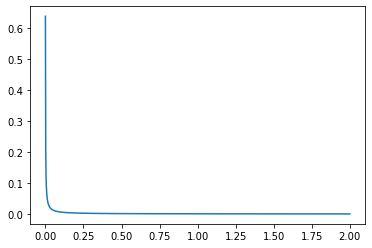

In [21]:
plt.plot(time[0:2000],cost[0:2000])

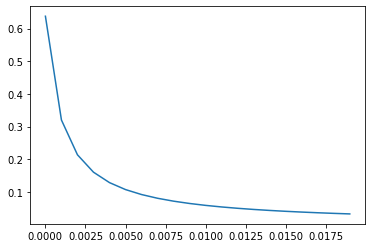

In [22]:
plt.plot(time[0:20],cost[0:20])

In [23]:
Final_Cost

466.99557191462236

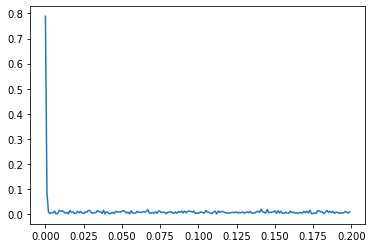

In [24]:
plt.plot(time[0:200],x_norm[0:200])

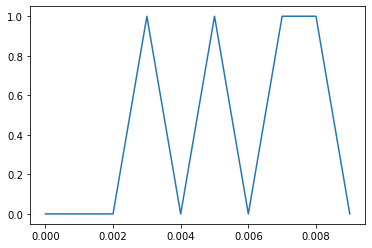

In [25]:
plt.plot(time[0:10],ms[0:10])

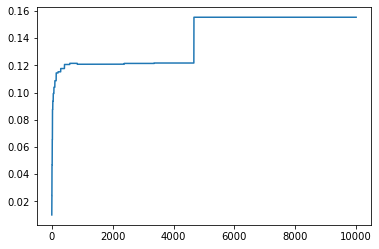

In [26]:
#Testing convergence of parameter estimation for mode a:
#print(LA.norm((Augmented-AtBt),'fro'))
erra=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsa[t],B_dynamicsa[t]))
    erra[t]=LA.norm((Augmenteda-AtBt),'fro')
    
plt.plot(time[0:time.shape[0]],erra[0:time.shape[0]])

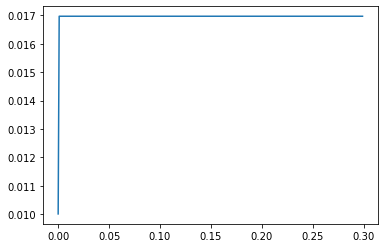

In [27]:
plt.plot(time[0:300],erra[0:300])

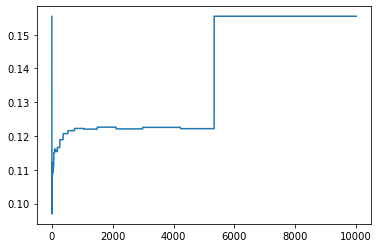

In [28]:
#Testing convergence of parameter estimation for mode b:
#print(LA.norm((Augmented-AtBt),'fro'))
errb=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsb[t],B_dynamicsb[t]))
    errb[t]=LA.norm((Augmentedb-AtBt),'fro')
    
plt.plot(time[10:time.shape[0]],errb[10:time.shape[0]])

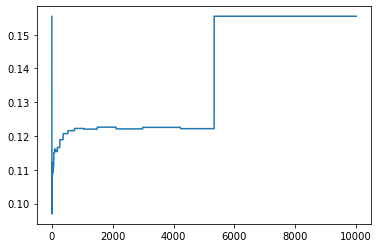

In [29]:
plt.plot(time[10:time.shape[0]],errb[10:time.shape[0]])

In [30]:
print("Last Iterate Instantaneous cost of Modified OSLO:")
print(ct)

Last Iterate Instantaneous cost of Modified OSLO:
1.1149607716478047e-06


In [31]:
estimatea=np.column_stack((A0a,B0a))
estimateb=np.column_stack((A0b,B0b))

actuala=np.column_stack((A1,B1))
actualb=np.column_stack((A2,B2))

print(LA.norm((actuala-estimatea),'fro'))
print(LA.norm((actualb-estimateb),'fro'))


0.010008649890675759
0.009702519704738528


In [32]:
X=x_dynamicsa[:,1:acount+1]
Z=z_dynamicsa[:,0:acount]
AtBt=square_matrix_ridge_regression(Z,X,estimatea,lamdaa,betaa)
print(LA.norm((actuala-AtBt),'fro'))


X=x_dynamicsb[:,1:bcount+1]
Z=z_dynamicsb[:,0:bcount]
AtBt=square_matrix_ridge_regression(Z,X,estimateb,lamdab,betab)
print(LA.norm((actualb-AtBt),'fro'))





0.12179078125849072
0.12227316698493249


In [33]:
#Now we compare against the benchmark from Vijay Gupta's extension of the Riccati Equations based Optimal Policy


#Ricatti Solver and testing the average cost with this

Opt_x_dynamics=np.zeros((2,time.shape[0]))
Opt_x_0=np.random.rand(2)
Opt_x_dynamics[:,0]=Opt_x_0
Opt_x_dynamics
Opt_cost=np.zeros((time.shape[0]))
Opt_x_norm=np.zeros((time.shape[0]))



# Dynamic Programming for Riccati Solver Policies as in Vijay Gupta's MJLS notes: http://www.cds.caltech.edu/~murray/books/AM08/pdf/ncs-markjls_22Jan10.pdf


P1=np.zeros((time.shape[0],2,2))
K1=np.zeros((time.shape[0],2,2))
P2=np.zeros((time.shape[0],2,2))
K2=np.zeros((time.shape[0],2,2))
#zero_init=np.zeros((2,2))
for t in range((time.shape[0])):
    P1[t]=np.zeros((2,2))
    P2[t]=np.zeros((2,2))
    K1[t]=np.zeros((2,2))
    K2[t]=np.zeros((2,2))
P1[time.shape[0]-1]=Q
P2[time.shape[0]-1]=Q
K1[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,Q),B1)),B1.T),Q),A1)
K2[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,Q),B2)),B2.T),Q),A2)

for t in range(1,time.shape[0]):
    P1[time.shape[0]-t-1]=p*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+(1-p)*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    P2[time.shape[0]-t-1]=(1-q)*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+q*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    K1[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,P1[time.shape[0]-t]),B1)),B1.T),P1[time.shape[0]-t]),A1)
    K2[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,P1[time.shape[0]-t]),B2)),B2.T),P2[time.shape[0]-t]),A2)
















In [34]:
#Now we run the Riccati Optimal Policies

#First some initializations

markov_state=0
Opt_ms=np.zeros((time.shape[0]))
Opt_ms[0]=0

Opt_u_0= -K1[0].dot(Opt_x_0)

Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0)))

Opt_cost[0]=Opt_c_0
Opt_x_norm[0]=LA.norm(Opt_x_0,2)

#Now we simulate the Markov Jump Dynamical System, this time playing optimally using Riccati Policies

for t in range(1,time.shape[0]):
    xprev=Opt_x_dynamics[:,t-1]
    markov_state=Opt_ms[t-1]
    if (markov_state==0):
        uprev=-K1[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[p,1-p])
    else:
        uprev=-K2[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[1-q,q])    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
        ut=-K1[t].dot(xt)
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,np.sqrt(var2),xprev.shape)
        ut=-K2[t].dot(xt)
    nct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(Opt_cost[t-1]*(t)+ct)/(t+1)
    Opt_x_norm[t]=LA.norm(xt,2)
    Opt_cost[t]=c
    Opt_ms[t]=markov_state
    Opt_x_dynamics[:,t]=xt

Opt_Final_Cost=(Opt_cost[time.shape[0]-1]*(time.shape[0])+Opt_x_dynamics[:,time.shape[0]-1].dot(Q.dot(Opt_x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)

Opt_Final_Cost*=(time.shape[0]+1)



In [35]:
Opt_Final_Cost

11.251556819364405

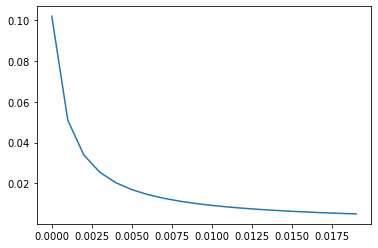

In [36]:
plt.plot(time[0:20],Opt_cost[0:20])

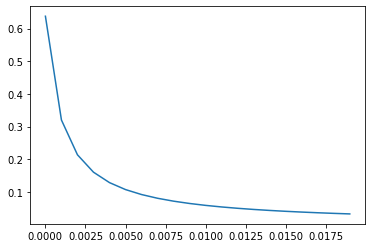

In [37]:
plt.plot(time[0:20],cost[0:20])

In [38]:
avg_regret=np.zeros((time.shape[0]))
frac_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    avg_regret[t]=cost[t]-Opt_cost[t]
    frac_regret[t]=avg_regret[t]/Opt_cost[t]
    

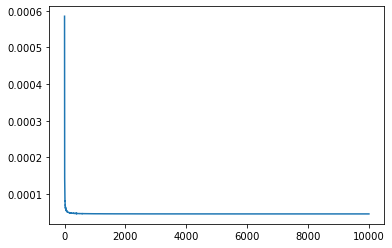

In [39]:
plt.plot(time[1000:time.shape[0]],avg_regret[1000:time.shape[0]])

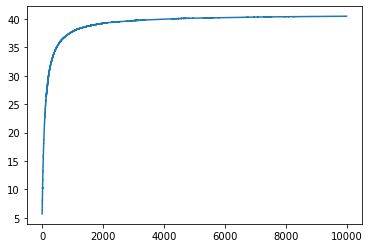

In [40]:
plt.plot(time[1000:time.shape[0]],frac_regret[1000:time.shape[0]])

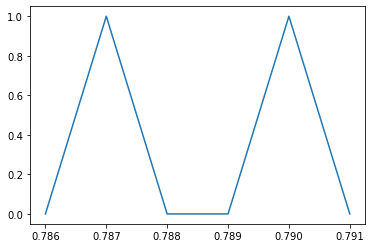

In [41]:
plt.plot(time[786:792],Opt_ms[786:792])

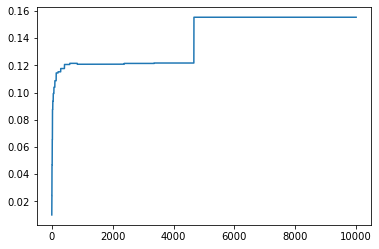

In [42]:
#Testing convergence of parameter estimation for mode a:
#print(LA.norm((Augmented-AtBt),'fro'))
err=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsa[t],B_dynamicsa[t]))
    err[t]=LA.norm((Augmenteda-AtBt),'fro')
    
plt.plot(time[0:time.shape[0]],err[0:time.shape[0]])

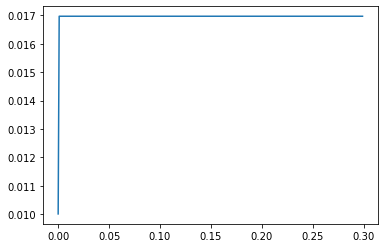

In [43]:
plt.plot(time[0:300],err[0:300])

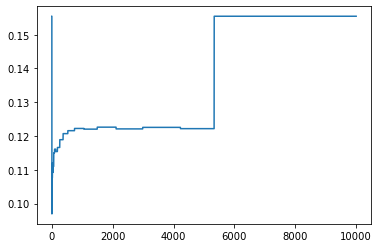

In [44]:
#Testing convergence of parameter estimation for mode b:
#print(LA.norm((Augmented-AtBt),'fro'))
err=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsb[t],B_dynamicsb[t]))
    err[t]=LA.norm((Augmentedb-AtBt),'fro')
    
plt.plot(time[0:time.shape[0]],err[0:time.shape[0]])

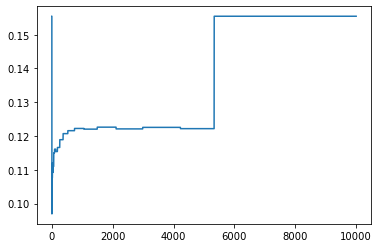

In [45]:
plt.plot(time[0:time.shape[0]],err[0:time.shape[0]])

In [46]:
print("Last Iterate Instantaneous cost of Modified OSLO:")
print(ct)

Last Iterate Instantaneous cost of Modified OSLO:
1.1149607716478047e-06


In [47]:
print("Last Iterate Instantaneous cost of Vijay Gupta's Riccati:")
print(nct)

Last Iterate Instantaneous cost of Vijay Gupta's Riccati:
4.7052863034595045e-05


In [48]:
dill.dump_session('notebook_env.db')

In [49]:
print(acount)

4667157


In [50]:
print(bcount)

5332843


In [51]:
print(acount+bcount)


10000000


In [52]:
estimatea=np.column_stack((A0a,B0a))
estimateb=np.column_stack((A0b,B0b))

In [53]:
actuala=np.column_stack((A1,B1))
actualb=np.column_stack((A2,B2))

In [54]:
print(LA.norm((actuala-estimatea),'fro'))
print(LA.norm((actualb-estimateb),'fro'))

0.010008649890675759
0.009702519704738528


In [55]:
X=x_dynamicsb[:,1:bcount+1]
Z=z_dynamicsb[:,0:bcount]
AtBt=square_matrix_ridge_regression(Z,X,estimateb,lamdab,betab)
print(LA.norm((actualb-AtBt),'fro'))

0.12227316698493249


In [56]:
X=x_dynamicsa[:,1:acount+1]
Z=z_dynamicsa[:,0:acount]
AtBt=square_matrix_ridge_regression(Z,X,estimatea,lamdaa,betaa)
print(LA.norm((actuala-AtBt),'fro'))

0.12179078125849072


In [57]:
K_dynamicsb[100]

array([[-0.00482802, -0.00248314],
       [-0.00636866, -0.00321073]])

In [58]:
K2[100]

array([[0.00449112, 0.00212775],
       [0.00550676, 0.00256386]])

In [59]:
K1[100]

array([[0.00340508, 0.0019643 ],
       [0.0059273 , 0.00332454]])

In [60]:
K_dynamicsa[100]

array([[-0.00372804, -0.00160902],
       [-0.0055671 , -0.00228204]])

In [61]:
K_dynamicsa[0]

array([[-0.00436857, -0.00258206],
       [-0.00654921, -0.00377831]])

In [62]:
K_dynamicsb[0]

array([[-0.00482802, -0.00248314],
       [-0.00636866, -0.00321073]])